In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge

In [2]:
# Read Files
users_df = pd.read_csv('users.csv')
suggestions_df = pd.read_csv('suggestions.csv', encoding='latin1')
jbsteps_df = pd.read_csv('jbsteps.csv')
gfsteps_df = pd.read_csv('gfsteps.csv')

# Check information of data
print(users_df.info())
print(suggestions_df.info())
print(jbsteps_df.info())
print(gfsteps_df.info())

# sample some datas
print(users_df.head())
print(suggestions_df.head())
print(jbsteps_df.head())
print(gfsteps_df.head())


C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\1000227188.py:3: DtypeWarning: Columns (21,22,38,39,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  suggestions_df = pd.read_csv('suggestions.csv', encoding='latin1')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Columns: 117 entries, user.index to ipaq.hepa.exit
dtypes: bool(1), float64(31), int64(54), object(31)
memory usage: 33.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8274 entries, 0 to 8273
Data columns (total 86 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user.index                     8274 non-null   int64  
 1   decision.index                 8274 non-null   int64  
 2   decision.index.nogap           7884 non-null   float64
 3   sugg.select.utime              8273 non-null   object 
 4   sugg.select.slot               8274 non-null   int64  
 5   sugg.select.update             8274 non-null   object 
 6   sugg.tz                        7539 non-null   object 
 7   sugg.gmtoff                    8273 non-null   float64
 8   sugg.decision.utime            8273 non-null   object 
 9   sugg.decision.slot         

In [3]:
suggestions_df['reward.jbsteps_transformed'] = np.log1p(suggestions_df['jbsteps60'])
suggestions_df['reward.jbsteps.zero_transformed'] = np.log1p(suggestions_df['jbsteps60.zero'])
suggestions_df['reward.gfsteps_transformed'] = np.log1p(suggestions_df['gfsteps60'])

In [4]:
print(suggestions_df['reward.jbsteps_transformed'].head(3))
print(suggestions_df['reward.jbsteps.zero_transformed'].head(3))
print(suggestions_df['reward.gfsteps_transformed'].head(3))

0    7.254178
1    6.028279
2    6.161207
Name: reward.jbsteps_transformed, dtype: float64
0    7.254178
1    6.028279
2    6.161207
Name: reward.jbsteps.zero_transformed, dtype: float64
0    6.855409
1    0.000000
2    0.000000
Name: reward.gfsteps_transformed, dtype: float64


In [5]:
merged_df = pd.merge(suggestions_df, users_df, on='user.index', how='inner')

In [6]:
# Identify numeric columns
numeric_columns = merged_df.select_dtypes(include=['number']).columns
# Fill NaN values in numeric columns with the median
merged_df[numeric_columns] = merged_df[numeric_columns].fillna(merged_df[numeric_columns].median())

# For non-numeric columns, you can fill with mode
non_numeric_columns = merged_df.select_dtypes(exclude=['number']).columns
for column in non_numeric_columns:
    merged_df[column] = merged_df[column].fillna(merged_df[column].mode()[0])

C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\1178703336.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df[column] = merged_df[column].fillna(merged_df[column].mode()[0])


In [7]:
print(merged_df.isnull().sum().sum())  # Check how many missing values exist in each column

0


In [8]:
# Function to check if a column can be converted to datetime
def is_datetime_column(col):
    try:
        # Try converting the column to datetime
        pd.to_datetime(merged_df[col], errors='raise')
        return True
    except (ValueError, TypeError):
        return False

# Identify columns that are of object dtype and could be datetime strings
potential_datetime_columns = [col for col in merged_df.select_dtypes(include=['object']).columns if is_datetime_column(col)]

C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\3458525242.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(merged_df[col], errors='raise')
C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\3458525242.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(merged_df[col], errors='raise')
C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\3458525242.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(merged_df[col], errors='raise')
C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\3458525242.py:5: UserWarning: 

In [9]:
# Convert identified datetime columns to datetime type
for col in potential_datetime_columns:
    merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')

# Verify the conversion
print(merged_df[potential_datetime_columns].dtypes)

sugg.select.utime      datetime64[ns]
sugg.select.update     datetime64[ns]
sugg.decision.utime    datetime64[ns]
sugg.context.utime     datetime64[ns]
sugg.response.utime    datetime64[ns]
intake.survey.utime    datetime64[ns]
first.notif.utime      datetime64[ns]
first.steps.utime      datetime64[ns]
exit.survey.utime      datetime64[ns]
last.notif.utime       datetime64[ns]
last.steps.utime       datetime64[ns]
travel.start           datetime64[ns]
travel.end             datetime64[ns]
dropout.date           datetime64[ns]
dtype: object


In [10]:
exclude_columns = ['sugg.select.update', 'travel.start', 'travel.end', 'dropout.date']
potential_datetime_columns = [col for col in potential_datetime_columns if col not in exclude_columns]

In [11]:
# Extract date-time components for the identified columns
for col in potential_datetime_columns:
    merged_df[f'{col}_month'] = merged_df[col].dt.month
    merged_df[f'{col}_day'] = merged_df[col].dt.day
    merged_df[f'{col}_hour'] = merged_df[col].dt.hour
    merged_df[f'{col}_minute'] = merged_df[col].dt.minute
    merged_df[f'{col}_second'] = merged_df[col].dt.second
    
for col in exclude_columns:
    merged_df[f'{col}_month'] = merged_df[col].dt.month
    merged_df[f'{col}_day'] = merged_df[col].dt.day

# Verify the changes
print(merged_df[[f'{col}_month' for col in potential_datetime_columns]].head())
print(merged_df[[f'{col}_day' for col in potential_datetime_columns]].head())
print(merged_df[[f'{col}_hour' for col in potential_datetime_columns]].head())
print(merged_df[[f'{col}_minute' for col in potential_datetime_columns]].head())
print(merged_df[[f'{col}_second' for col in potential_datetime_columns]].head())

   sugg.select.utime_month  sugg.decision.utime_month  \
0                        7                          7   
1                        7                          7   
2                        7                          7   
3                        7                          7   
4                        7                          7   

   sugg.context.utime_month  sugg.response.utime_month  \
0                         7                          7   
1                         7                          7   
2                         7                         12   
3                         7                         12   
4                         7                         12   

   intake.survey.utime_month  first.notif.utime_month  \
0                          7                        7   
1                          7                        7   
2                          7                        7   
3                          7                        7   
4                      

C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\3927575607.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'{col}_month'] = merged_df[col].dt.month
C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\3927575607.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'{col}_day'] = merged_df[col].dt.day
C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\3927575607.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [12]:
# Split on ':' to separate the hour-like and minute-like components
merged_df[['elapsed_hour', 'minute_with_fraction']] = merged_df['sugg.device.utime'].str.split(':', expand=True)

# Convert to integers or floats (handle fractional seconds if needed)
merged_df['elapsed_hour'] = pd.to_numeric(merged_df['elapsed_hour'], errors='coerce')
merged_df['elapsed_minute'] = pd.to_numeric(merged_df['minute_with_fraction'].str.split('.').str[0], errors='coerce')

# Optionally compute total elapsed minutes for a unified numeric representation
merged_df['total_elapsed_minutes'] = merged_df['elapsed_hour'] * 60 + merged_df['elapsed_minute']

# Optionally, keep decomposed hour and minute (or drop intermediate columns)
merged_df.drop(columns=['minute_with_fraction'], inplace=True)
merged_df.drop(columns=['elapsed_hour'], inplace=True)
merged_df.drop(columns=['elapsed_minute'], inplace=True)


C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\518594258.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[['elapsed_hour', 'minute_with_fraction']] = merged_df['sugg.device.utime'].str.split(':', expand=True)
C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\518594258.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[['elapsed_hour', 'minute_with_fraction']] = merged_df['sugg.device.utime'].str.split(':', expand=True)
C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\518594258.py:6: Per

In [13]:
print(merged_df.isnull().sum().sum())  # Check how many missing values exist in each column

0


In [14]:
merged_df = merged_df.drop(columns=potential_datetime_columns)
merged_df = merged_df.drop(columns=exclude_columns)

In [15]:
non_numeric_columns = merged_df.select_dtypes(exclude=['number']).columns
non_numeric_columns

Index(['sugg.tz', 'sugg.device.utime', 'connect', 'is.randomized',
       'snooze.status', 'intransit', 'avail', 'send', 'send.active',
       'send.sedentary', 'is.prefetch', 'recognized.activity',
       'recognized.activity.response', 'tag.active', 'tag.indoor',
       'tag.outdoor', 'tag.outdoor_snow', 'front.end.application',
       'returned.message', 'response', 'dec.city', 'dec.location.exact',
       'dec.location.category', 'dec.weather.condition', 'dec.windspeed',
       'dec.precipitation.chance', 'response.city', 'response.location.exact',
       'response.location.category', 'response.weather.condition',
       'response.windspeed', 'response.precipitation.chance',
       'intake.survey.tz', 'exit.survey.tz', 'own.phone', 'gender', 'marital',
       'marother', 'ethnicity', 'ethother', 'occupation', 'education',
       'vacation', 'sms', 'messaging', 'call', 'email', 'calendar', 'web',
       'social', 'other.mobile', 'fitapp', 'fitapp.names', 'fittracker',
       'fittra

In [16]:
# Convert the relevant columns to numeric (float)
numeric_columns = ['dec.windspeed', 'dec.precipitation.chance', 'response.windspeed', 'response.precipitation.chance']
merged_df[numeric_columns] = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
merged_df[numeric_columns] = merged_df[numeric_columns].fillna(merged_df[numeric_columns].median())

# Verify the transformation
print(merged_df[numeric_columns].head())


   dec.windspeed  dec.precipitation.chance  response.windspeed  \
0            3.0                       0.0                 3.0   
1            1.6                       0.0                 1.6   
2            3.7                       0.0                 0.0   
3            0.0                       0.0                 0.0   
4            0.0                       0.0                 0.0   

   response.precipitation.chance  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  


In [17]:
print(merged_df.isnull().sum().sum())  # Check how many missing values exist in each column

0


In [18]:
merged_df = merged_df.drop(columns=['sugg.tz','intake.survey.tz', 'exit.survey.tz'])

In [19]:
non_numeric_columns = merged_df.select_dtypes(exclude=['number']).columns
non_numeric_columns

Index(['sugg.device.utime', 'connect', 'is.randomized', 'snooze.status',
       'intransit', 'avail', 'send', 'send.active', 'send.sedentary',
       'is.prefetch', 'recognized.activity', 'recognized.activity.response',
       'tag.active', 'tag.indoor', 'tag.outdoor', 'tag.outdoor_snow',
       'front.end.application', 'returned.message', 'response', 'dec.city',
       'dec.location.exact', 'dec.location.category', 'dec.weather.condition',
       'response.city', 'response.location.exact',
       'response.location.category', 'response.weather.condition', 'own.phone',
       'gender', 'marital', 'marother', 'ethnicity', 'ethother', 'occupation',
       'education', 'vacation', 'sms', 'messaging', 'call', 'email',
       'calendar', 'web', 'social', 'other.mobile', 'fitapp', 'fitapp.names',
       'fittracker', 'fittracker.names'],
      dtype='object')

In [20]:
label_encoder = LabelEncoder()
for col in non_numeric_columns:
    merged_df[col] = label_encoder.fit_transform(merged_df[col])

In [21]:
non_numeric_columns = merged_df.select_dtypes(exclude=['number']).columns
non_numeric_columns

Index([], dtype='object')

In [22]:
merged_df.shape

(8274, 247)

In [23]:
merged_df['jbsteps60pre']

0        874.0
1        622.0
2        456.0
3       4175.0
4          0.0
         ...  
8269     278.0
8270     151.0
8271     409.0
8272      14.0
8273     114.0
Name: jbsteps60pre, Length: 8274, dtype: float64

In [24]:
import re

# Use regular expressions to match column name patterns
pattern = r'jbsteps|jbmins|gfsteps|gfmins'  # The regex pattern can be expanded to match other patterns

# Find all columns that match the pattern
columns_to_drop = [col for col in merged_df.columns if ((re.search(pattern, col)) and (not col.endswith('pre') or col.endswith('pre.zero')))]

# Exclude the column 'reward.jbsteps_transformed'
columns_to_drop = [col for col in columns_to_drop if col != 'reward.jbsteps_transformed']

# Drop these columns
merged_df = merged_df.drop(columns=columns_to_drop)

In [25]:
merged_df.shape

(8274, 218)

In [26]:
merged_df.columns

Index(['user.index', 'decision.index', 'decision.index.nogap',
       'sugg.select.slot', 'sugg.gmtoff', 'sugg.decision.slot',
       'sugg.device.utime', 'sugg.device.since', 'interaction.count',
       'connect',
       ...
       'last.steps.utime_second', 'sugg.select.update_month',
       'sugg.select.update_day', 'travel.start_month', 'travel.start_day',
       'travel.end_month', 'travel.end_day', 'dropout.date_month',
       'dropout.date_day', 'total_elapsed_minutes'],
      dtype='object', length=218)

In [27]:
X = merged_df.drop(columns=['reward.jbsteps_transformed'])
y = merged_df['reward.jbsteps_transformed']

# RandomForestRegressor

In [28]:
# model = RandomForestRegressor(n_estimators=100, random_state=42)

# # Using  RFE
# rfe = RFE(estimator=model, n_features_to_select=20)  # Select most imprtant 20 features
# rfe.fit(X, y)

# # Show selected columns
# selected_columns = X.columns[rfe.support_]
# print(f"Selected features: {selected_columns.tolist()}")

In [29]:
# selected_columns = ['decision.index', 'decision.index.nogap', 'sugg.device.utime', 'sugg.device.since', 'returned.message', 'dec.location.exact', 'dec.location.category', 'dec.temperature', 'dec.windspeed', 'response.temperature', 'occupation', 'other.mobile', 'sugg.select.utime_day', 'sugg.select.utime_hour', 'sugg.decision.utime_hour', 'sugg.decision.utime_minute', 'sugg.context.utime_day', 'intake.survey.utime_minute', 'sugg.select.update_day', 'total_elapsed_minutes', 'send']
# selected_columns = ['decision.index', 'decision.index.nogap', 'sugg.select.slot', 'sugg.device.utime', 'sugg.device.since', 'returned.message', 'dec.location.exact', 'dec.location.category', 'dec.temperature', 'dec.windspeed', 'response.temperature', 'jbmins30pre', 'jbsteps30pre', 'jbsteps40pre', 'jbsteps60pre', 'gfsteps60pre', 'metmins.intake', 'sugg.decision.utime_day', 'sugg.decision.utime_hour', 'intake.survey.utime_second', 'send']

In [30]:
# selected_columns = ['decision.index', 'decision.index.nogap', 'sugg.select.slot', 'sugg.device.utime', 'sugg.device.since', 'returned.message', 'dec.location.exact', 'dec.location.category', 'dec.temperature', 'dec.windspeed', 'response.temperature', 'jbmins30pre', 'jbsteps30pre', 'jbsteps40pre', 'jbsteps60pre', 'gfsteps60pre', 'metmins.intake', 'sugg.decision.utime_day', 'sugg.decision.utime_hour', 'intake.survey.utime_second', 'send']
# state_columns = selected_columns
# action_column = "send"  # "send" is the name of action column
# reward_column = 'reward.jbsteps_transformed'  # reward variable

# # 準備輸入資料
# X = merged_df[state_columns]
# y = merged_df[reward_column]

# action_column = X.columns.get_loc("send")

In [31]:
# # Split to training and testing data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# # Training Reward Model
# reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
# reward_model.fit(X_train, y_train)

In [32]:
# def thompson_sampling_with_rf(X_test, reward_model):
#     n_trees = len(reward_model.estimators_)
#     n_samples = X_test.shape[0]
#     predictions_action1 = []
#     predictions_action0 = []
    
#     # Use each tree as a sample of the prediction
#     for tree in reward_model.estimators_:
#         X_test_action1 = X_test.copy()
#         X_test_action1[action_column] = 1 
#         X_test_action0 = X_test.copy()
#         X_test_action0[action_column] = 0
        
#         predictions_action1.append(tree.predict(X_test_action1))
#         predictions_action0.append(tree.predict(X_test_action0))
    
#     # Convert to arrays for easier handling
#     predictions_action1 = np.array(predictions_action1)
#     predictions_action0 = np.array(predictions_action0)
    
#     # Sample mean reward from tree-based predictions for each action
#     chosen_actions = []
#     for i in range(n_samples):
#         reward1_sample = np.random.choice(predictions_action1[:, i])
#         reward0_sample = np.random.choice(predictions_action0[:, i])
#         chosen_actions.append(1 if reward1_sample > reward0_sample else 0)
    
#     return chosen_actions

# # Example usage
# reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
# reward_model.fit(X_train, y_train)  # Fit the model with training data
# chosen_actions = thompson_sampling_with_rf(X_test, reward_model)


In [33]:
# reward_model.feature_importances_

In [34]:
# feature_names = pd.DataFrame(X_train).columns
# importances = reward_model.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(12, 6))
# plt.title("Feature Importances")
# plt.bar(range(X_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
# plt.tight_layout()
# plt.show()


In [35]:
# print(chosen_actions.count(0))
# print(chosen_actions.count(1))

# BaysianRidge As Prior Identification

In [ ]:
selected_columns = ['decision.index', 'decision.index.nogap', 'sugg.select.slot', 'sugg.device.utime', 'sugg.device.since', 'returned.message', 'dec.location.exact', 'dec.location.category', 'dec.temperature', 'dec.windspeed', 'response.temperature', 'jbmins30pre', 'jbsteps30pre', 'jbsteps40pre', 'jbsteps60pre', 'gfsteps60pre', 'metmins.intake', 'sugg.decision.utime_day', 'sugg.decision.utime_hour', 'intake.survey.utime_second', 'send']
state_columns = selected_columns
action_column = "send"  # "send" is the name of action column
reward_column = 'reward.jbsteps_transformed'  # reward variable

X = merged_df[state_columns]
y = merged_df[reward_column]

action_column = X.columns.get_loc("send")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
def thompson_sampling_with_bayesian_ridge(X_test, reward_model):
    # Extract the number of sample
    n_samples = X_test.shape[0]
    
    # Predict the reward for 0(not sending message) and 1(sending message)
    X_action1 = X_test.copy()
    X_action1[action_column] = 1
    X_action0 = X_test.copy()
    X_action0[action_column] = 0
    
    # Use Bayesian Ridge to predict mean, std of reward
    mean_reward1, std_reward1 = reward_model.predict(X_action1, return_std=True)
    mean_reward0, std_reward0 = reward_model.predict(X_action0, return_std=True)
    
    # Thompson Sampling
    chosen_actions = []
    for i in range(n_samples):
        # Random Sampling reward
        reward1_sample = np.random.normal(mean_reward1[i], std_reward1[i])
        reward0_sample = np.random.normal(mean_reward0[i], std_reward0[i])
        # Choose the action based on reward
        chosen_actions.append(1 if reward1_sample > reward0_sample else 0)
    
    return chosen_actions

# Train Bayesian Ridge Model
reward_model = BayesianRidge()
reward_model.fit(X_train, y_train)

# Use trained reward model to implement Thompson Sampling
chosen_actions = thompson_sampling_with_bayesian_ridge(X_test, reward_model)

In [51]:
print("Not Sending Messages: ", chosen_actions.count(0))
print("Sending Messages: ", chosen_actions.count(1))

Not Sending Messages:  1221
Sending Messages:  1262


# Evaluation

In [39]:
selected_columns = ['decision.index', 'decision.index.nogap', 'sugg.select.slot', 'sugg.device.utime', 'sugg.device.since', 'returned.message', 'dec.location.exact', 'dec.location.category', 'dec.temperature', 'dec.windspeed', 'response.temperature', 'jbmins30pre', 'jbsteps30pre', 'jbsteps40pre', 'jbsteps60pre', 'gfsteps60pre', 'metmins.intake', 'sugg.decision.utime_day', 'sugg.decision.utime_hour', 'intake.survey.utime_second', 'send']
state_columns = selected_columns
action_column = "send"  # "send" is the name of action column
reward_column = 'reward.jbsteps_transformed'  # reward variable

X = merged_df[state_columns]
y = merged_df[reward_column]

action_column = X.columns.get_loc("send")

In [40]:
def simulate_environment(state, action, reward_model):
    state_with_action = state.copy()
    state_with_action[action_column] = action  # Assume action_column is set
    predicted_reward = reward_model.predict(state_with_action.reshape(1, -1))
    return np.random.normal(predicted_reward, 0.1)  # Add small noise for realism

In [41]:
def vanilla_ts_algorithm(X_test, reward_model, n_steps=1000):
    n_samples = X_test.shape[0]
    rewards = []
    chosen_actions = []
    
    for _ in range(n_steps):
        actions = thompson_sampling_with_bayesian_ridge(X_test, reward_model)  # Get actions for all rows
        step_rewards = []
        for i in range(n_samples):  # Loop over each row (sample)
            reward = simulate_environment(X_test[i], actions[i], reward_model)
            step_rewards.append(reward)
        
        rewards.append(np.mean(step_rewards))  # Store the average reward of this step
        chosen_actions.append(actions)
        
    return rewards, chosen_actions


In [43]:
all_rewards = []
n_simulations = 100
for _ in range(n_simulations):
    rewards, _ = vanilla_ts_algorithm(X_test, reward_model)
    all_rewards.append(np.cumsum(rewards))  # Track cumulative reward

average_rewards = np.mean(all_rewards, axis=0)

In [58]:
len(all_rewards[0])

2483

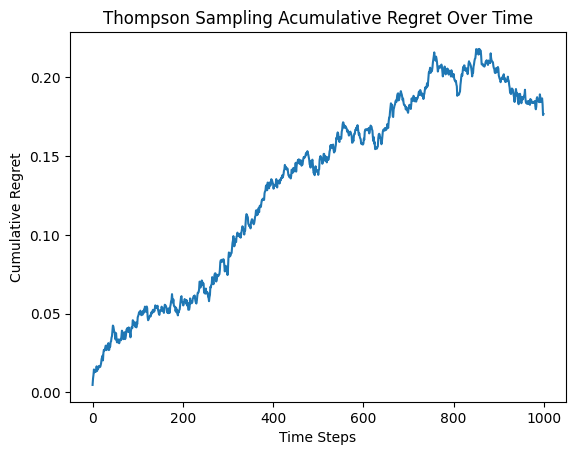

In [59]:
optimal_rewards = np.max(all_rewards, axis=0)  # Assuming you know the optimal strategy
cumulative_regret = optimal_rewards - average_rewards

plt.plot(cumulative_regret)
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.title('Thompson Sampling Acumulative Regret Over Time')
plt.show()

C:\Users\oscar10408\AppData\Local\Temp\ipykernel_14296\4116212786.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  regret = [cumulative_regret[i]/i for i in range(1000)]


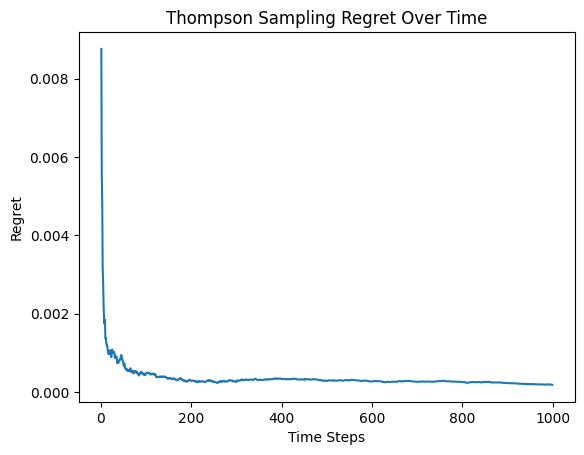

In [60]:
regret = [cumulative_regret[i]/i for i in range(1000)]

plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')
plt.title('Thompson Sampling Regret Over Time')
plt.show()

In [ ]:
# selected_columns# Calculate the correlation of the selected features with the target variable
# correlations = merged_df[['reward.jbsteps_transformed'] + selected_columns.tolist()].corr()

# # Display the correlation between each feature and the target
# print(correlations['reward.jbsteps_transformed'].sort_values(ascending=False))


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calculate the correlation matrix for the selected features
# corr_matrix = merged_df[['reward.jbsteps_transformed'] + selected_columns.tolist()].corr()

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
# plt.show()


In [119]:
# state_columns = selected_columns
# reward_column = 'reward.jbsteps_transformed'

# X = merged_df[state_columns].values
# y = merged_df[reward_column].values

# print(merged_df.head())

In [575]:

# reward_model = LinearRegression()
# reward_model.fit(X, y)

# test_state = X[0]
# predicted_reward = reward_model.predict([test_state])[0]
# print(f"Predicted reward for test state: {predicted_reward}")


Predicted reward for test state: 5.021957473038658


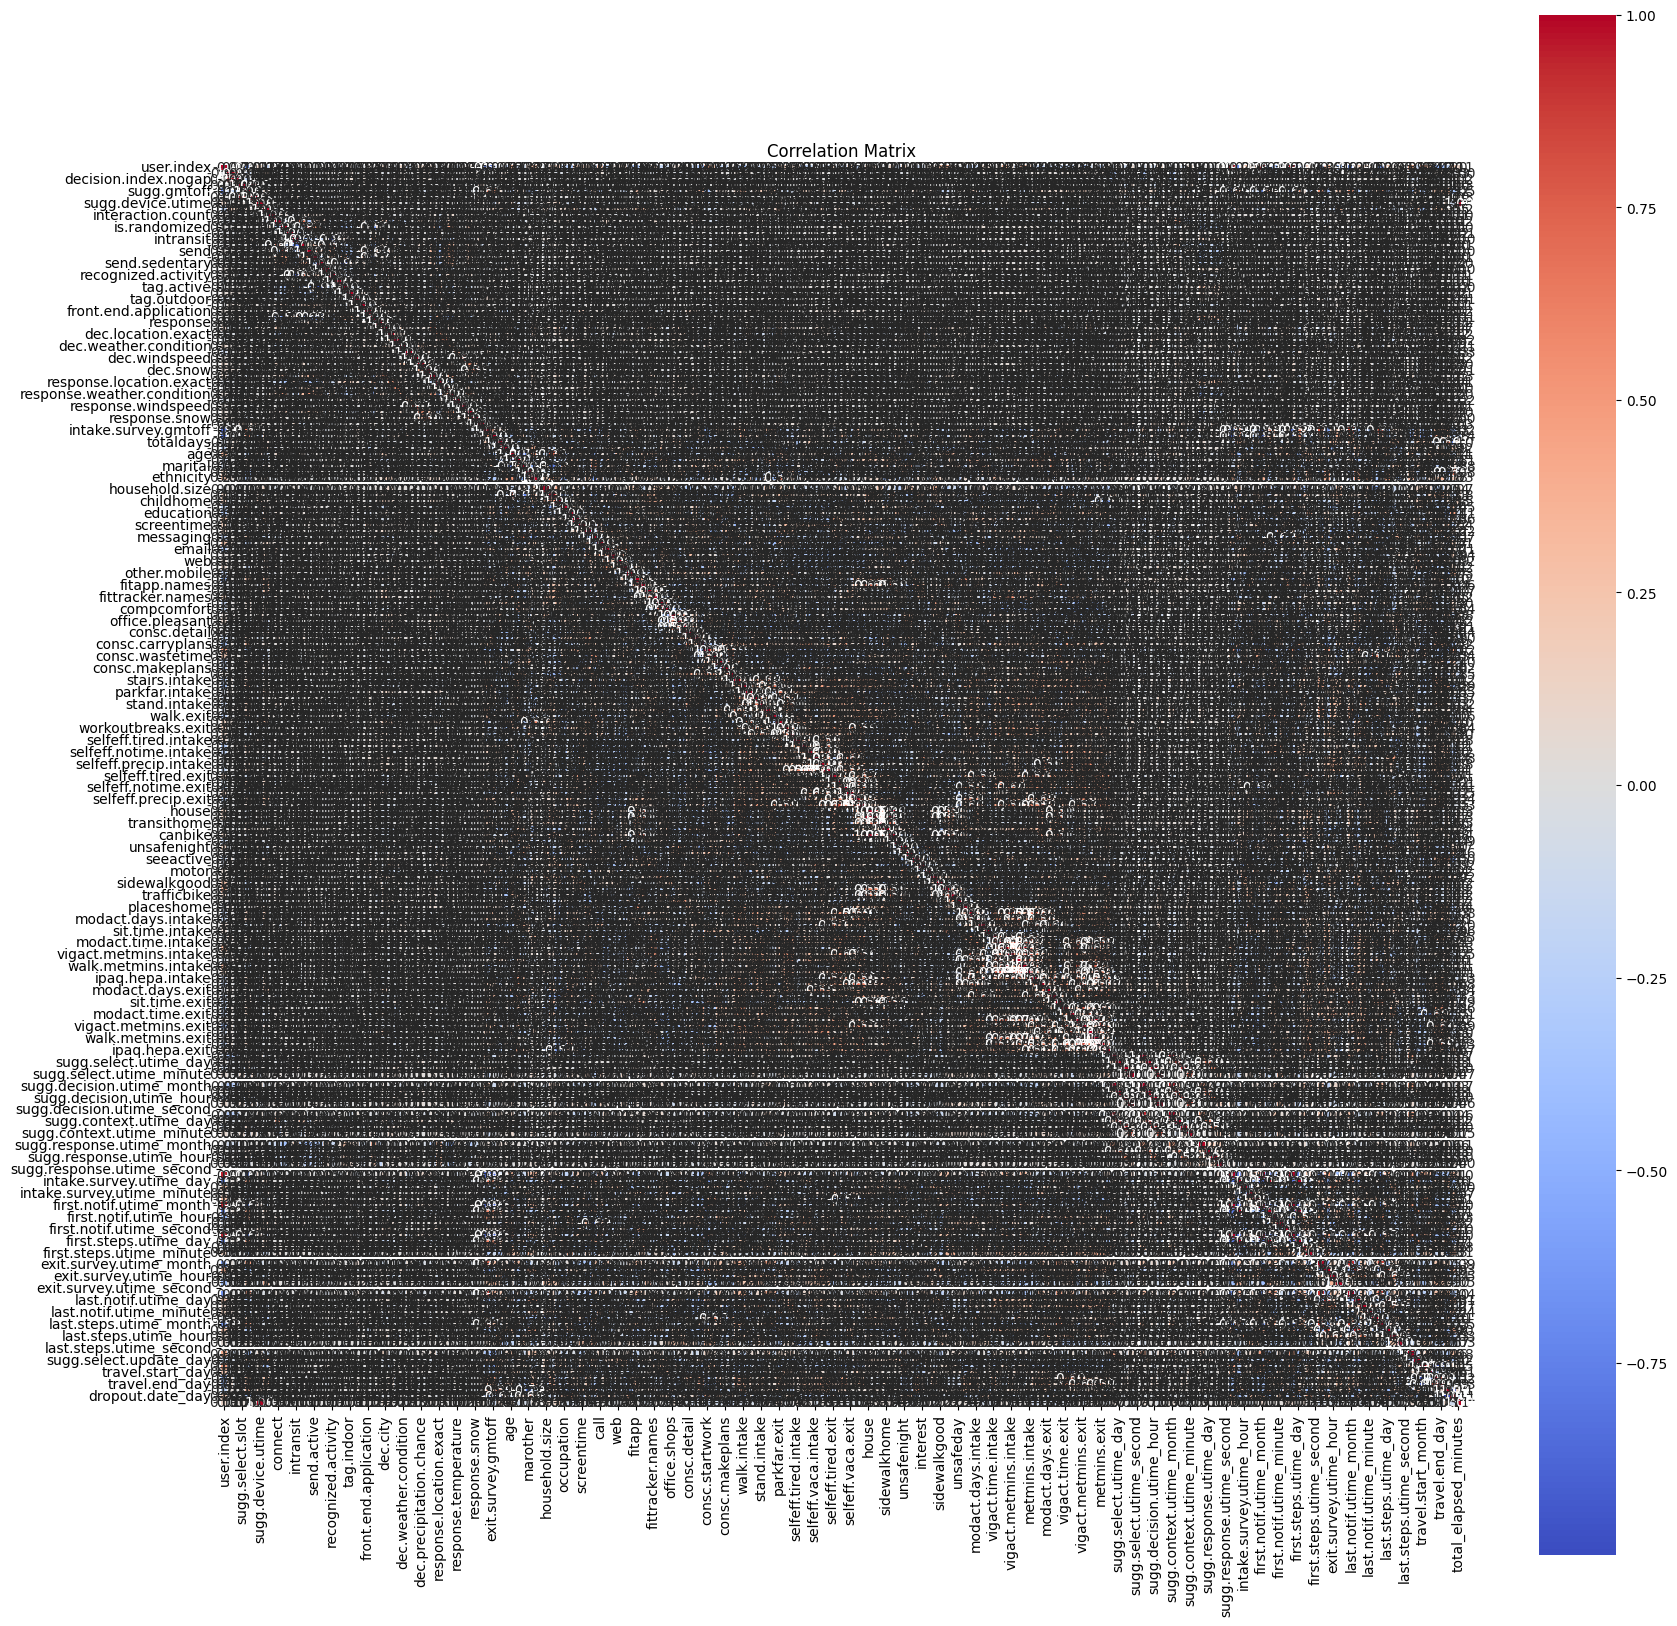

In [512]:
# Compute the correlation matrix
corr_matrix = merged_df.corr()

# Generate a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation Matrix")
plt.show()